# Imports

In [1]:
import sys
import os


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
print(sys.path[-1])

/home/cotsios/dsit/2nd-semester/ml-in-comp-bio/Assignment-1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import umap

from scipy import stats

from src.visualization import (
    plot_kde,
    plot_animated_scatter_notebook_only,
    plot_zeros,
    plot_feature_spans,
    plot_correlation_coefficients,
    plot_correlated_pairplot
)

# Paths

In [3]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data")
print(DATA_DIR)

/home/cotsios/dsit/2nd-semester/ml-in-comp-bio/Assignment-1/data


# The data

I will merge the valuation and the devolepment sets to get a bigger data set for my preliminary analyses.

In [4]:
val_file_name = "assignment1_val_set.csv"
dev_file_name = "assignment1_dev_set.csv"

val_set = pd.read_csv(os.path.join(DATA_DIR, val_file_name), index_col=0)
dev_set = pd.read_csv(os.path.join(DATA_DIR, dev_file_name), index_col=0)

df = pd.concat([val_set, dev_set], axis=0)
df.reset_index(drop=True, inplace=True)

cols = df.columns

In [5]:
display(df.shape)
display(cols)

(700, 140)

Index(['Project ID', 'Experiment type', 'Sex', 'Host age', 'BMI',
       'Disease MESH ID', 'Acholeplasma axanthum',
       'Acidaminococcus fermentans', 'Acidaminococcus intestini',
       'Actinomyces lingnae',
       ...
       'Clostridium sphenoides', 'Clostridium spiroforme',
       'Clostridium stercorarium', 'Clostridium symbiosum',
       'Clostridium thermosuccinogenes', 'Clostridium xylanolyticum',
       'Eubacterium brachy', 'Eubacterium dolichum', 'Eubacterium sulci',
       'Ruminococcus gnavus'],
      dtype='object', length=140)

We can see that the `BMI` column is the 6<sup>th</sup> one and the bacterial concentrations start from the 8<sup>th</sup> column up to the last (141<sup>st
</sup>)  
Also, since we want to classify `BMI` based **only** on the bacteria in the gut microbiome, we can **exclude** the following columns:
- `Project ID`
- `Experiment type`
- `Disease MESH ID`

Regarding the `Sex` and `Host age` columns, I decided to separate them in order to examine them one by one, and not with the bacterial data.

In [6]:
# drop columns Project ID, Experiment type, Sex, Host age, Disease MESH ID
cols_to_drop = [
    "Project ID",
    "Experiment type",
    "Sex",
    "Host age",
    "BMI",
    "Disease MESH ID"
]

bmi = df["BMI"]
sex = df["Sex"]
age = df["Host age"]
bacteria = df.drop(cols_to_drop, axis=1)

In [7]:
bacteria.head()

,Acholeplasma axanthum,Acidaminococcus fermentans,Acidaminococcus intestini,Actinomyces lingnae,Akkermansia muciniphila,Alistipes finegoldii,Alistipes indistinctus,Alistipes obesi,Alistipes onderdonkii,Alistipes putredinis,...,Clostridium sphenoides,Clostridium spiroforme,Clostridium stercorarium,Clostridium symbiosum,Clostridium thermosuccinogenes,Clostridium xylanolyticum,Eubacterium brachy,Eubacterium dolichum,Eubacterium sulci,Ruminococcus gnavus
0,0.0,0.000000,1.621960,0.0,0.000000,0.068238,0.020996,0.0,0.031494,0.493412,...,0.000000,2.871240,0.0,0.068238,0.115479,0.015747,0.010498,0.000000,0.010498,0.551152
1,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.002095,0.000000,0.0,0.002095,0.041895,0.000000,0.0,0.140346,0.714301,...,0.000000,0.064936,0.0,0.016758,0.000000,0.041895,0.010474,0.006284,0.014663,0.000000
3,0.0,0.000000,0.044998,0.0,0.013846,0.010384,0.000000,0.0,0.041537,0.034614,...,0.003461,0.089996,0.0,0.003461,0.006923,0.000000,0.000000,0.020768,0.034614,0.013846
4,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## General Overview

### BMI

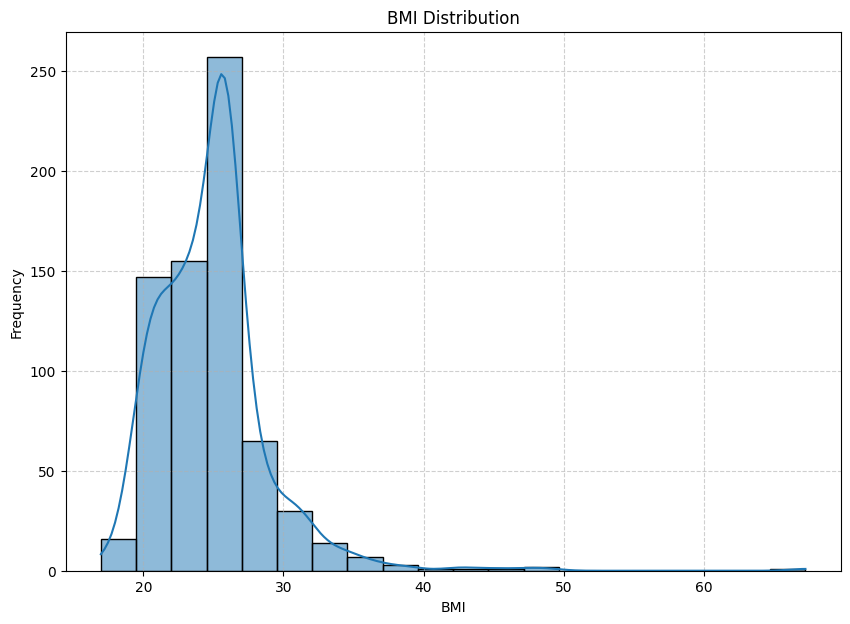

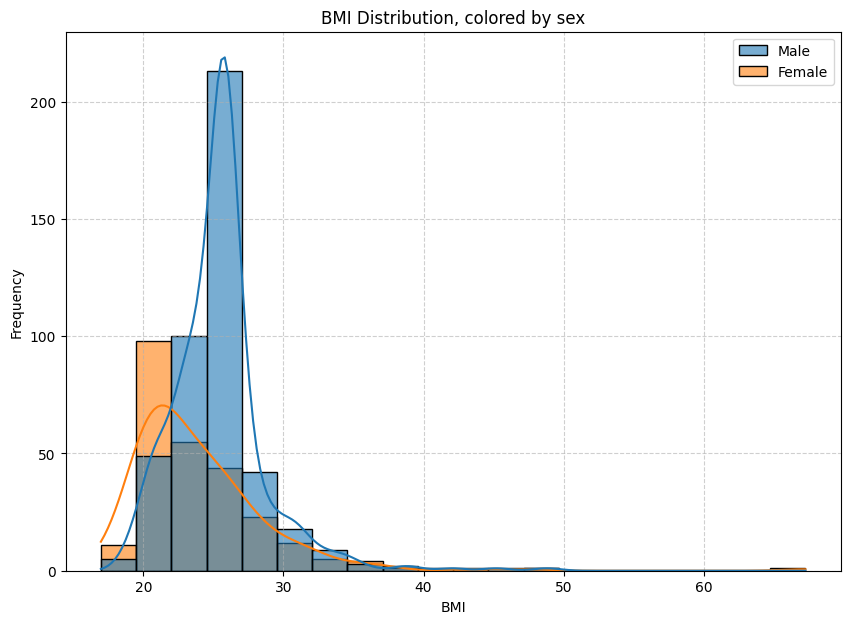

In [8]:
plot_kde(
    bmi,
    title="BMI Distribution",
    x_label="BMI"
)
plot_kde(
    bmi,
    title="BMI Distribution, colored by sex",
    x_label="BMI",
    hue_by=sex
)

In [9]:
# Perform the Lillefors (Kolmogorov-Smirnov) test for normality on BMI
alpha = 0.05
stat, p = stats.normaltest(bmi)
print(f"stat: {stat}, p: {p}")
if p < alpha:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected, the data is normally distributed")

stat: 483.0734341316214, p: 1.2645517335693436e-105
The null hypothesis can be rejected


### Bacteria

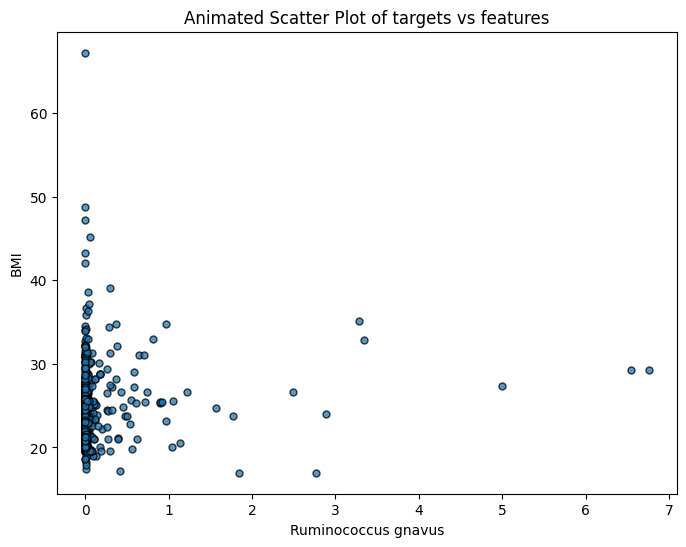

In [24]:
# Animated plot, please rerun this cell to see the animation if you missed it
plot_animated_scatter_notebook_only(bmi, bacteria, 0.25)

In [11]:
plot_zeros(bacteria)

In [12]:
plot_feature_spans(bacteria)

Lets normalize them and see what they look like.

In [13]:
zscaler = StandardScaler()
mmscaler = MinMaxScaler()

bacteria_zscaled = zscaler.fit_transform(bacteria)
bacteria_mmscaled = mmscaler.fit_transform(bacteria)

In [14]:
plot_feature_spans(bacteria_zscaled, title="Standardized Features")
plot_feature_spans(bacteria_mmscaled, title="MinMax Scaled Features")

### Sex and Age

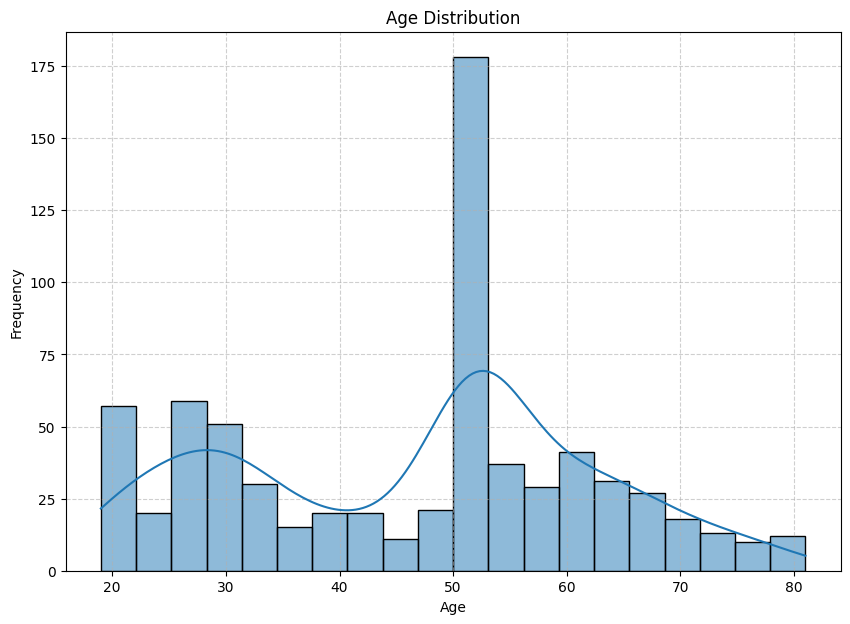

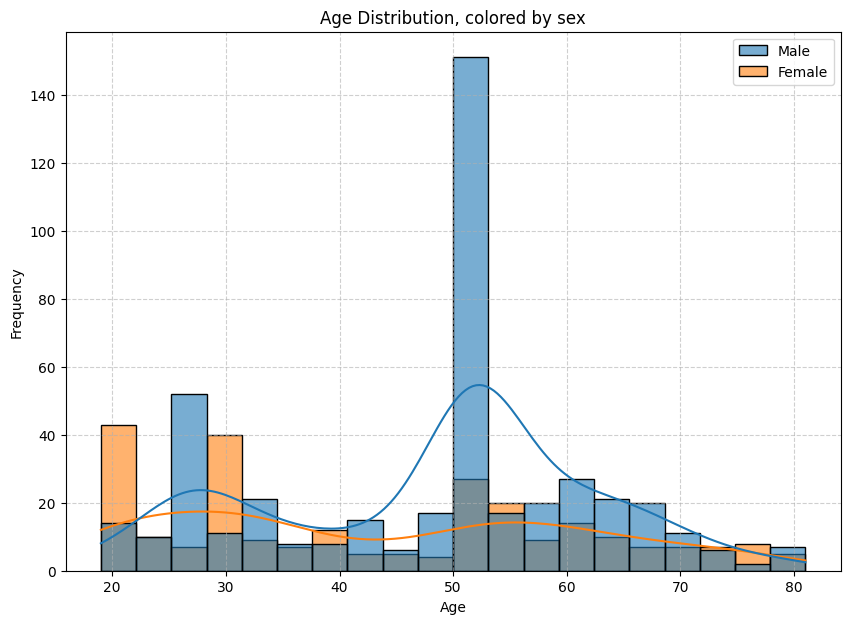

In [15]:
plot_kde(
    age,
    title="Age Distribution",
    x_label="Age"
)
plot_kde(
    age,
    title="Age Distribution, colored by sex",
    x_label="Age",
    hue_by=sex
)

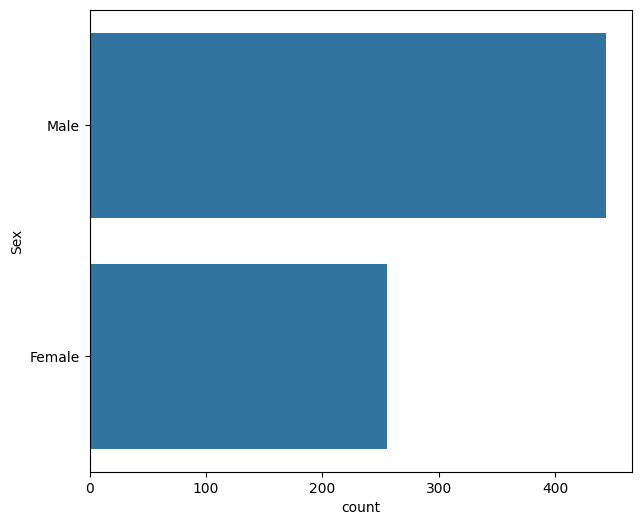

In [16]:
plt.figure(figsize=(7, 6))
sns.countplot(sex)
plt.show()

## Correlations

In [17]:
bacteria_corr_array_bmi, bactera_sorted_by_corr_bmi = plot_correlation_coefficients(
    bacteria,
    bmi,
    abs_corr=True,
    title="Correlation Coefficients (absolute values) of Bacteria against BMI"
)

In [18]:
bacteria_corr_array_age, bactera_sorted_by_corr_age = plot_correlation_coefficients(
    bacteria,
    age,
    abs_corr=True,
    title="Correlation Coefficients (absolute values) of Bacteria against age"
)

#### Correlation between features

Let's inspect the feature correlation of the top `n` most correlated bacteria with bmi.

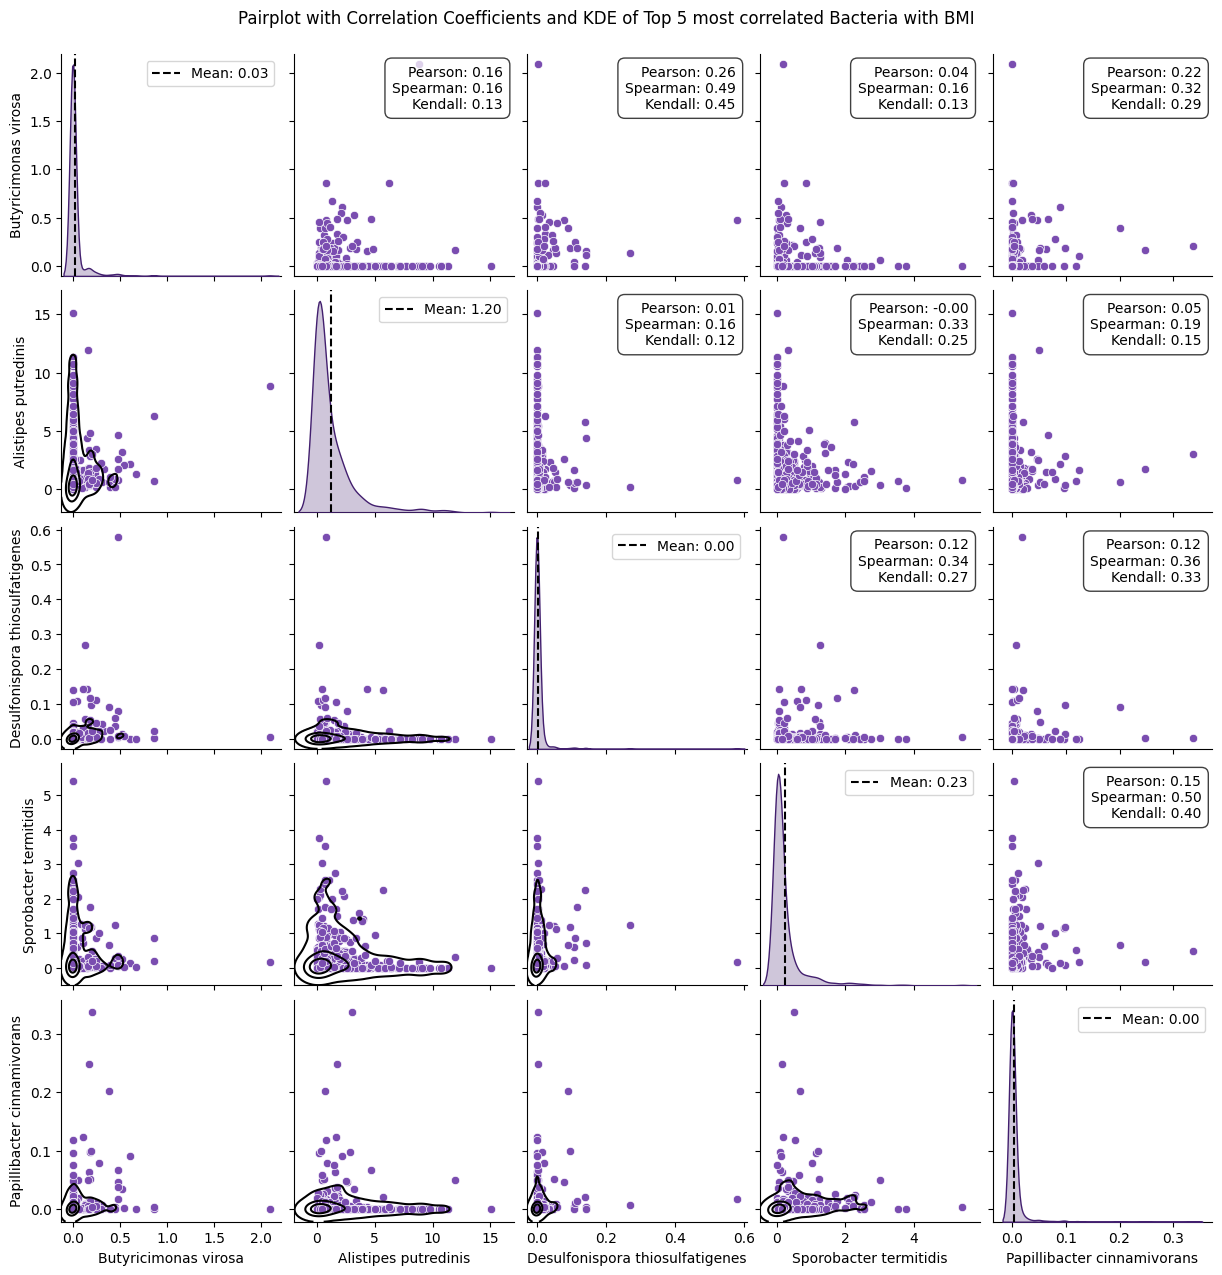

In [19]:
n = 5
first_n_bacteria_names = bactera_sorted_by_corr_bmi[:n]
first_n_bacteria = bacteria[first_n_bacteria_names]
plot_correlated_pairplot(
        first_n_bacteria,
        title="Pairplot with Correlation Coefficients and KDE of Top 5 most correlated Bacteria with BMI"
)

Same as above but for bacteria and age.

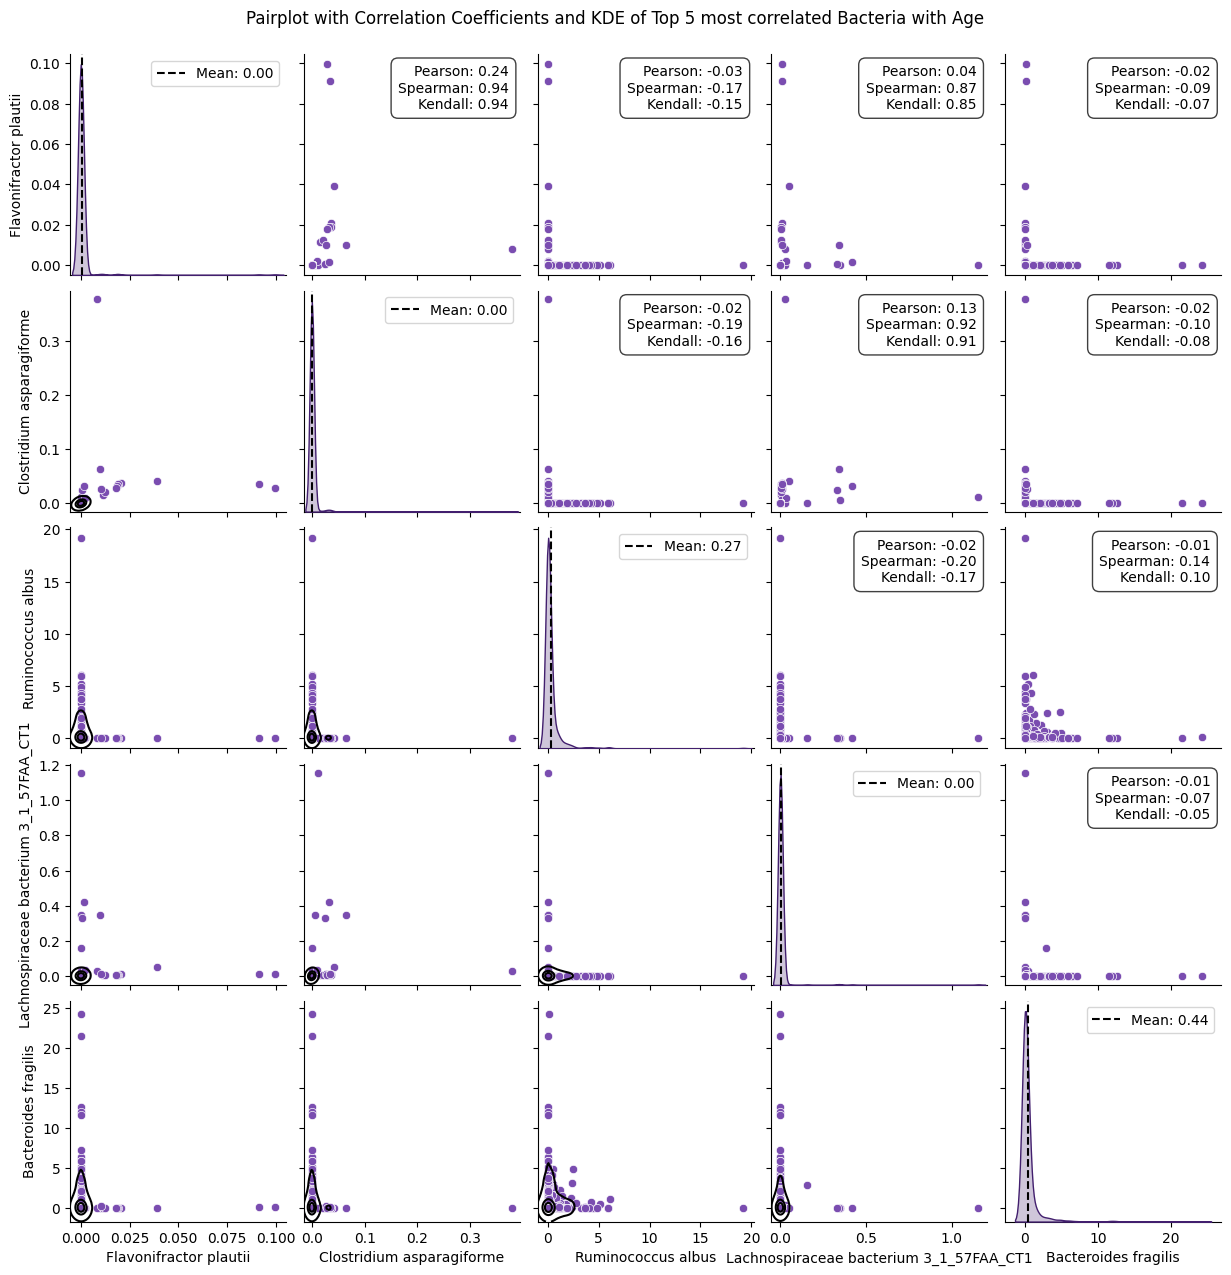

In [20]:
n = 5
first_n_bacteria_names = bactera_sorted_by_corr_age[:n]
first_n_bacteria = bacteria[first_n_bacteria_names]
plot_correlated_pairplot(
        first_n_bacteria,
        title="Pairplot with Correlation Coefficients and KDE of Top 5 most correlated Bacteria with Age"
)

## Visualizations on reduced dimensions on the feature space

Now lets inspect the feature space in reduced dimensions and see if we can find anything that might help us later on.

Number of components that explain 65% of the variance: 5


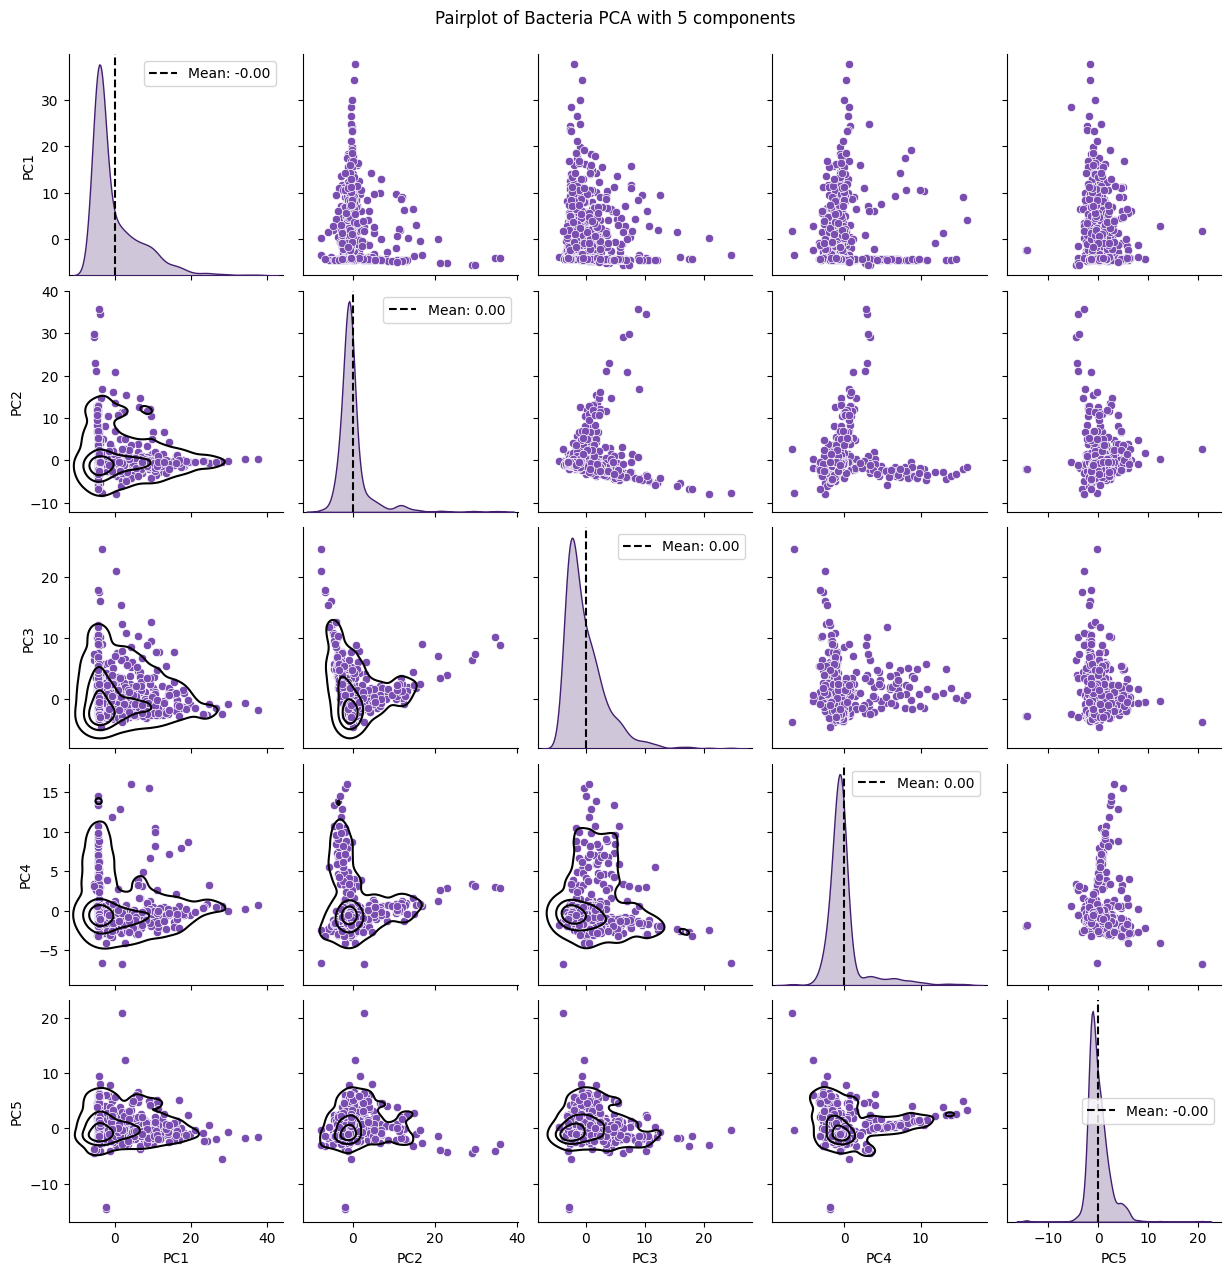

In [21]:
# PCA
pca = PCA()
bacteria_pca = pca.fit_transform(bacteria)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

n_components = np.argmax(cumulative_explained_variance_ratio > 0.65) + 1
print(f"Number of components that explain 65% of the variance: {n_components}")

plot_correlated_pairplot(
    pd.DataFrame(
        bacteria_pca[:, :n_components],
        columns=[f"PC{i}" for i in range(1, n_components + 1)]
    ),
    title=f"Pairplot of Bacteria PCA with {n_components} components",
    overlay_correlations=False
)

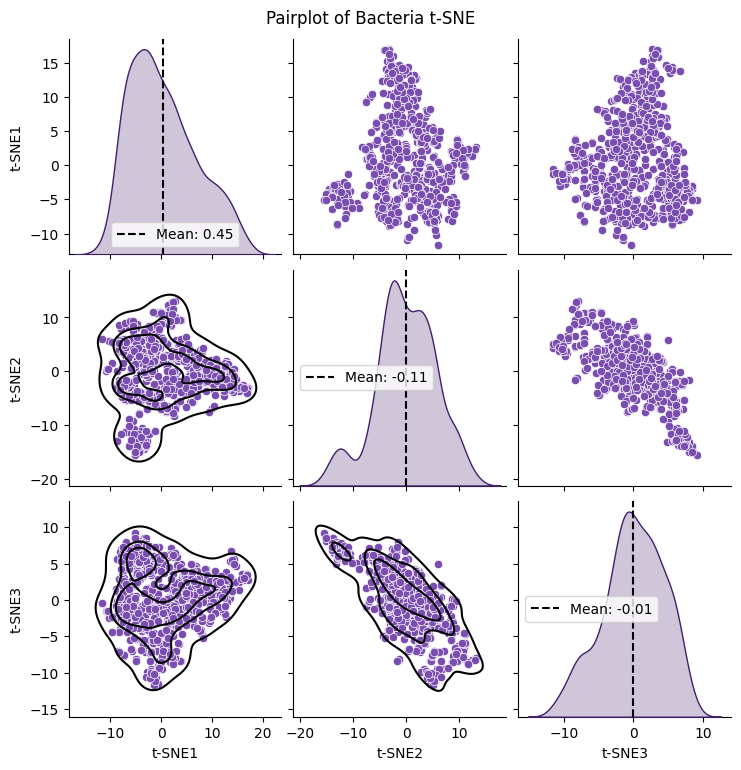

In [22]:
# t-SNE
tsne = TSNE(n_components=3)
bacteria_tsne = tsne.fit_transform(bacteria)

plot_correlated_pairplot(
    pd.DataFrame(
        bacteria_tsne,
        columns=[f"t-SNE{i}" for i in range(1, 4)]
    ),
    title="Pairplot of Bacteria t-SNE",
    overlay_correlations=False
)

/home/cotsios/dsit/2nd-semester/ml-in-comp-bio/Assignment-1/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



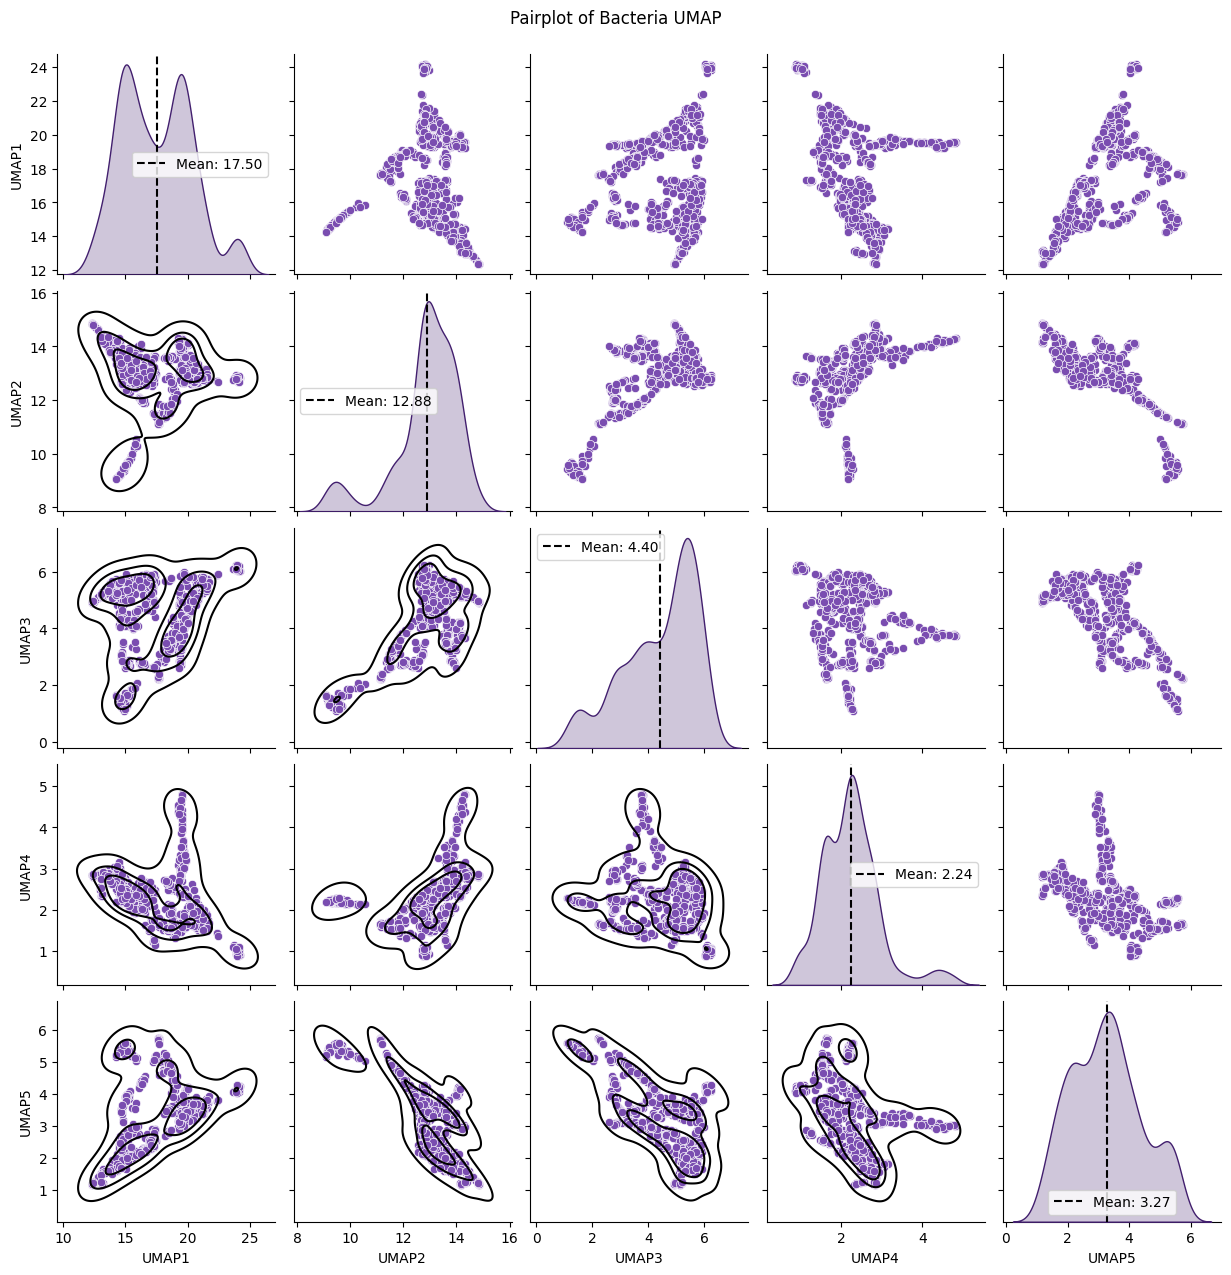

In [23]:
# UMAP
umap_model = umap.UMAP(n_components=5)
bacteria_umap = umap_model.fit_transform(bacteria)

plot_correlated_pairplot(
    pd.DataFrame(
        bacteria_umap,
        columns=[f"UMAP{i}" for i in range(1, 6)]
    ),
    title="Pairplot of Bacteria UMAP",
    overlay_correlations=False
)

# Conclusion

First we can observe that the`BMI` (dependent variable) does not follow the normal distribution, so a simple linear regression model like the least squares will
likely not work. One interesting thing to notice is that the male participants have a higher `BMI` than the female participants, which will likely play a role
in the final model.  
When observing the animated scatter plot we can see that there are not distinct bacterial species correlate with the `BMI` and also we can see that an
overwhelming majority of the `bacteria` have a value of zero.  
The features (`bacteria`) lie close to $0$ with only a few outliers as seen by their means and Inter Quantile Ranges (IQR). A MinMax normalization would make
the features very sparce in the range $[0, 1]$, so a Standardization seems like a better approach.  
Using **Pearson's**, **Spearman's**, and **Kendall's tau** correlation coefficients we see that there is not a single bacterial species that is highly
correlated (either positively or negatively) with `BMI`. Plotting a pairplot of the `n` most correlated features with `BMI` we can see that those features are
not highly correlated between them selves so at least they in theory carry different information and using them would be helpful.  
When using either of the three dimensionality reduction methods (**PCA**, **t-SNE**, **UMAP**) no visible clusters form, except for some slight clustering in
the case of **UMAP**.